# TP 2-3 : Branch-and-bound applied to a knapsack problem

### Initialisation (à faire une seule fois)

In [1]:
import Pkg; 
Pkg.add("GraphRecipes"); Pkg.add("Plots"); 
using GraphRecipes, Plots #only used to visualize the search tree at the end of the branch-and-bound

    Updating registry at `~/.julia/registries/General`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`


### Récupération des données

In [2]:
function readKnaptxtInstance(filename)
    price=[]
    weight=[]
    KnapCap=[]
    open(filename) do f
        for i in 1:3
            tok = split(readline(f))
            if(tok[1] == "ListPrices=")
                for i in 2:(length(tok)-1)
                    push!(price,parse(Int64, tok[i]))
                end
            elseif(tok[1] == "ListWeights=")
                for i in 2:(length(tok)-1)
                    push!(weight,parse(Int64, tok[i]))
                end
            elseif(tok[1] == "Capacity=")
                push!(KnapCap, parse(Int64, tok[2]))
            else
                println("Unknown read :", tok)
            end 
        end
    end
    capacity=KnapCap[1]
    return price, weight, capacity
end

readKnaptxtInstance (generic function with 1 method)

### Procédure d'application des tests de sondabilités TA, TO et TR pour le cas de la relaxation linéaire

In [3]:
function TestsSondabilite_relaxlin(model2, x, varsbin, BestProfit, Bestsol)
    TA, TO, TR = false, false, false
    if(termination_status(model2) == MOI.INFEASIBLE)#Test de faisabilite
        TA=true
        println("TA")
    elseif(objective_value(model2) <= BestProfit) #Test d'optimalite
        TO=true
        println("TO")
    elseif( prod(abs.([round.(v, digits=0) for v in value.(varsbin)]-value.(varsbin)) .<= fill(10^-5, size(varsbin))) 
        ) #Test de resolution
        TR=true
        println("TR")
        #if (value(benef) >= BestProfit)
        if (objective_value(model2) >= BestProfit)
            Bestsol = value.(x)
            #BestProfit=value(benef)
            BestProfit=objective_value(model2)
        end
    else
        println("non sondable")
    end
    TA, TO, TR, Bestsol, BestProfit
end

TestsSondabilite_relaxlin (generic function with 1 method)

### Procédure de séparation et stratégie d'exploration permettant de se placer au prochain noeud à traiter

In [4]:

function SeparerNoeud_relaxlin(varsshouldbebinary, listvars, listvals)
    # le noeud est non-sondable. Appliquer le critère de séparation pour le séparer en sous-noeuds 
    # et choisir un noeud-fils le plus à gauche   
    
    #find a fractionnal variable
    i, var = 1, 0
    while((i <= length(varsshouldbebinary)) && (var==0))
        #if(varsshouldbebinary[i] ∉ listvars)
        if(abs(round(value(varsshouldbebinary[i]), digits=0) - value(varsshouldbebinary[i]) ) >= 10^-5)
            var=varsshouldbebinary[i]
        end
        i+=1
    end
    
    #=
    #find most fractionnal variable ?
    i, var, maxfrac = -1, 0, 0.0
    for i in 1:length(varsshouldbebinary)
        if(abs(round(value(varsshouldbebinary[i]), digits=0) - value(varsshouldbebinary[i]) ) >= maxfrac) 
            #if a variable is more fractinonal
            var=varsshouldbebinary[i]
            maxfrac=abs(round(value(varsshouldbebinary[i]), digits=0) - value(varsshouldbebinary[i]) )
            #println(i, " ", var, " ", maxfrac)
        end
    end
    =#
    

    set_lower_bound(var,1.0)
    set_upper_bound(var,1.0)

    push!(listvars,var) #stocker l'identite de la variable choisie pour la séparation
    push!(listvals,1.0) #stocker la branche choisie, identifiee par la valeur de la variable choisie
    listvars, listvals
end


function ExplorerAutreNoeud_relaxlin(listvars, listvals, listnodes)
    #this node is sondable, go back to parent node then right child if possible
    
    stop=false
    #check if we are not at the root node
    if (length(listvars)>= 1)
        #go back to parent node
        var=pop!(listvars)
        theval=pop!(listvals)
        tmp=pop!(listnodes)
        set_lower_bound(var,0.0)
        set_upper_bound(var,1.0)

        #go to right child if possible, otherwise go back to parent
        while( (theval==0.0) && (length(listvars)>= 1))
            var=pop!(listvars)
            theval=pop!(listvals)
            tmp=pop!(listnodes)
            set_lower_bound(var,0.0) 
            set_upper_bound(var,1.0)
        end
        if theval==1.0
            set_lower_bound(var,0.0)
            set_upper_bound(var,0.0)
            push!(listvars,var)
            push!(listvals,0.0)
        else
            println("\nFINISHED")
            stop=true
        end
    else
        #the root node was sondable
        println("\nFINISHED")
        stop=true
    end
    listvars, listvals, listnodes, stop 
end

ExplorerAutreNoeud_relaxlin (generic function with 1 method)

###  Création de la relaxation linéaire (= modèle associé au noeud 0): <span style="color:red"> SECTION A SUPPRIMER !!!! </span>

<span style="color:red"> Cette section est à commenter/supprimer et remplacer par vos propres calculs de bornes supérieures et autres, par exemple basées sur les bornes 1 et 2 vues en cours, ou d'autres calculs de bornes de votre choix/conception validés au préalable par votre encadrant/e de TP </span>

In [5]:
Pkg.add("Clp");
using JuMP, Clp

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`


In [6]:
function CreationModeleLP(price, weight, capacity)
# ROOT NODE
    
    model2 = Model(Clp.Optimizer) # set optimizer
    set_optimizer_attribute(model2, "LogLevel", 0) #don't display anything during solve
    set_optimizer_attribute(model2, "Algorithm", 4) #LP solver chosen is simplex

    # define x variables as CONTINUOUS (recall that it is not possible to define binary variables in Clp)
    @variable(model2, 0 <= x[i in 1:4] <= 1)
    varsshouldbebinary=[x[1] x[2] x[3] x[4]]

    # define objective function
    @objective(model2, Max, sum(price[i]*x[i] for i in 1:4))

    # define the capacity constraint 
    @constraint(model2, sum(weight[i]*x[i] for i in 1:4) <=  capacity)

    println(model2)

    return model2, x, varsshouldbebinary
end


CreationModeleLP (generic function with 1 method)

### Boucle principale : résoudre la relaxation linéaire, appliquer les tests de sondabilité, identifier le prochain noeud, répéter.

In [7]:

function SolveKnapInstance(filename)

    if (split(filename,"/")[end] != "test.opb.txt")
        println("This version of the code works only for the test instance !!!!")
    else
        price, weight, capacity = readKnaptxtInstance(filename)
        model2, x, varsshouldbebinary = CreationModeleLP(price, weight, capacity)
    
        #create the structure to memorize the search tree for visualization at the end
        trParentnodes=Int64[] #will store orig node of arc in search tree
        trChildnodes=Int64[] #will store destination node of arc in search tree
        trNamenodes=[] #will store names of nodes in search tree
         
        #intermediate structure to navigate in the search tree
        listvars=[]
        listvals=[]
        listnodes=[]

        BestProfit=-1
        Bestsol=[]

        current_node_number=0
        stop = false

        while(!stop)

            println("\nNode number ", current_node_number, ": \n-----\n", model2)

            #Update the search tree
            push!(trNamenodes,current_node_number+1) 
            if(length(trNamenodes)>=2)
                push!(trParentnodes,listnodes[end]+1) # +1 because the 1st node is "node 0"
                push!(trChildnodes, current_node_number+1) # +1 because the 1st node is "node 0"
            end
            push!(listnodes, current_node_number)


            print("Solve model2 to compute the bounds of the current node: start ... ")
            status = optimize!(model2)
            println("... end")

            print("\nSolution relax lin"); 
            if(termination_status(model2) == MOI.INFEASIBLE)#(has_values(model2))
                print(" : NOT AVAILABLE (probably infeasible or ressources limit reached)")
            else
                [print("\t", name(v),"=",value(v)) for v in all_variables(model2)] 
            end
            println(" "); println("\nPrevious Solution memorized ", Bestsol, " with bestprofit ", BestProfit, "\n")

            TA, TO, TR, Bestsol, BestProfit = TestsSondabilite_relaxlin(model2, x, varsshouldbebinary, BestProfit, Bestsol)

            is_node_sondable = TA || TO || TR

            if(!is_node_sondable)
                listvars, listvals = SeparerNoeud_relaxlin(varsshouldbebinary, listvars, listvals)
            else
                listvars, listvals, listnodes, stop = ExplorerAutreNoeud_relaxlin(listvars, listvals, listnodes)
            end

            current_node_number = current_node_number + 1
        end

        println("\n******\n\nOptimal value = ", BestProfit, "\n\nOptimal x=", Bestsol)

        return BestProfit, Bestsol, trParentnodes, trChildnodes, trNamenodes
    end

end


SolveKnapInstance (generic function with 1 method)

### Affichage du résultat final

Max 42 x[1] + 40 x[2] + 12 x[3] + 25 x[4]
Subject to
 7 x[1] + 4 x[2] + 3 x[3] + 5 x[4] ≤ 10.0
 x[1] ≥ 0.0
 x[2] ≥ 0.0
 x[3] ≥ 0.0
 x[4] ≥ 0.0
 x[1] ≤ 1.0
 x[2] ≤ 1.0
 x[3] ≤ 1.0
 x[4] ≤ 1.0


Node number 0: 
-----
Max 42 x[1] + 40 x[2] + 12 x[3] + 25 x[4]
Subject to
 7 x[1] + 4 x[2] + 3 x[3] + 5 x[4] ≤ 10.0
 x[1] ≥ 0.0
 x[2] ≥ 0.0
 x[3] ≥ 0.0
 x[4] ≥ 0.0
 x[1] ≤ 1.0
 x[2] ≤ 1.0
 x[3] ≤ 1.0
 x[4] ≤ 1.0

Solve model2 to compute the bounds of the current node: start ... ... end

Solution relax lin	x[1]=0.857142857142857	x[2]=1.0	x[3]=0.0	x[4]=0.0 

Previous Solution memorized Any[] with bestprofit -1

non sondable

Node number 1: 
-----
Max 42 x[1] + 40 x[2] + 12 x[3] + 25 x[4]
Subject to
 7 x[1] + 4 x[2] + 3 x[3] + 5 x[4] ≤ 10.0
 x[1] ≥ 1.0
 x[2] ≥ 0.0
 x[3] ≥ 0.0
 x[4] ≥ 0.0
 x[1] ≤ 1.0
 x[2] ≤ 1.0
 x[3] ≤ 1.0
 x[4] ≤ 1.0

Solve model2 to compute the bounds of the current node: start ... ... end

Solution relax lin	x[1]=1.0	x[2]=0.7500000000000001	x[3]=0.0	x[4]=0.0 

Previous Solution 

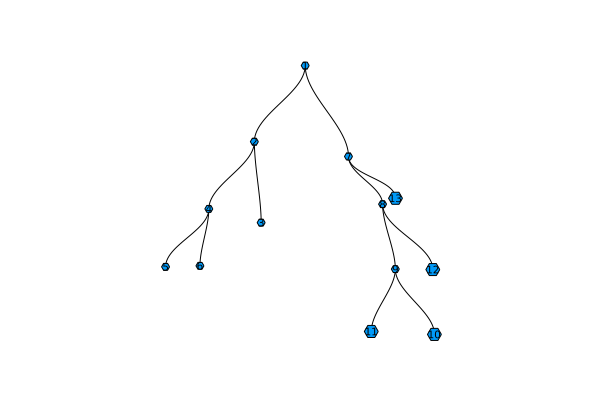

In [8]:
BestProfit, Bestsol, trParentnodes, trChildnodes, trNamenodes = SolveKnapInstance("instancesETU/KNAPnewformat/test.opb.txt")
println("\n******\n\nOptimal value = ", BestProfit, "\n\nOptimal x=", Bestsol)
graphplot(trParentnodes, trChildnodes, names=trNamenodes, method=:tree)